In [1]:
!pip install pyDOE

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/


In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from torch.autograd import grad
from pyDOE import lhs
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    #torch.backends.cuda.matmul.allow_tf32 = False
    #torch.backends.cudnn.allow_tf32 = False
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    
setup_seed(1234)

torch.backends.cuda.matmul.allow_tf32 = (
    False  # This is for Nvidia Ampere GPU Architechture
)
torch.backends.cudnn.allow_tf32 = False


   
    
class ResBlock(nn.Module):
    def __init__(self, n_node):
        super(ResBlock, self).__init__()
        self.linear0 = torch.nn.Linear(n_node, n_node)
        self.linear1 = torch.nn.Linear(n_node, n_node)
        self.activation = torch.nn.GELU()
        nn.init.xavier_normal_(self.linear0.weight)
        nn.init.constant_(self.linear0.bias, 0)
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.constant_(self.linear1.bias, 0)
        

    def forward(self, x):
        out = self.linear0(x)                   
        out = self.activation(out)
        out = out+x                               
        return out
        



class NetResDeep(nn.Module):
    def __init__(self, dim_in, dim_out, n_block, n_node,ub, lb):
        super().__init__()
        self.fc1 = nn.Linear(n_node, n_node)
        self.activation = torch.nn.GELU()
        self.resblocks = nn.Sequential(*[ResBlock(n_node=n_node) for _ in range(n_block)])
        self.fc2 = nn.Linear(2*n_node, dim_out)
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        
        
        self.A0 = 1*torch.randn((dim_in,int(n_node/2))).to(device)
        self.A1 = 5*torch.randn((dim_in,int(n_node/2))).to(device)
       
    def forward(self, x):       
        out = x
        out0 = out@self.A0
        out00 = torch.sin(out0)
        out01 = torch.cos(out0)
        out0 = torch.cat((out00,out01),1)
        out0 = self.fc1(out0)
        out0=self.activation(out0)
        out0 = self.resblocks(out0)


        out1 = out@self.A1
        out10 = torch.sin(out1)
        out11 = torch.cos(out1)
        out1 = torch.cat((out10,out11),1)
        out1 = self.fc1(out1)
        out1=self.activation(out1)
        out1 = self.resblocks(out1)


        
        out = torch.cat((out0,out1),1)
        out = self.fc2(out)
        return out



def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)


        
        
        
def rhs(x):

    # Right-Hand-Side of the Poisson equation
        return 2*torch.exp(-((x[:,0:1]-0.5)**2)/(2*h*h))+((((x[:,0:1]-0.5)**2)/(1*h*h)-1)*(x[:,1:2]**2+1000)*torch.exp(-((x[:,0:1]-0.5)**2)/(2*h*h)))/h**2
        
    
    
def u_r(x):

    # Right-Hand-Side of the Poisson equation
        return 1+(1000+(x[:,1:2])**2)*np.exp(-(x[:,0:1]-0.5)**2/(2*h*h))
    

    
    
    
    

    
    


# Parameters
x_min = 0
x_max = 1
y_min = 0
y_max = 1

h=0.05

ub = np.array([x_max, y_max])
lb = np.array([x_min, y_min])


N_bc = 300
N_f = 10000




x_points = lambda n: np.random.uniform(x_min, x_max, (n, 1))
y_points = lambda n: np.random.uniform(y_min, y_max, (n, 1))




class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net=NetResDeep(dim_in=2, dim_out=1, n_block=3, n_node=50, ub=ub, lb=lb).to(device)
        self.iter = 0
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=200,
            tolerance_grad=1e-12,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        self.adam = torch.optim.Adam(self.net.parameters(), lr=2e-3)
        self.scheduler=torch.optim.lr_scheduler.StepLR(self.adam,step_size=30,gamma=0.99)
        self.losses = {"loss": [], "bc": [], "pde": [],"pde2": []}
        #self.at=0
    

    def loss_bc(self, xyt):
        u = self.net(xyt)
        mse_bc = torch.mean(torch.square(u - u_bc))
        return mse_bc

    def loss_pde(self, xyt):
        xy = xyt.clone()
        xy.requires_grad = True

        u = self.net(xy)

        u_xyt = grad(u.sum(), xy, create_graph=True)[0]
        u_xx = grad(u_xyt[:, 0:1].sum(), xy, create_graph=True)[0][:, 0:1]
        u_yy = grad(u_xyt[:, 1:2].sum(), xy, create_graph=True)[0][:, 1:2]
        
        
        pde = rhs(xy)-(u_xx + u_yy)
        
        return pde

    def closure(self):
        temp=int(N_f/m/n)
        self.optimizer.zero_grad()
        self.adam.zero_grad()
        mse_bc = self.loss_bc(xy_bc)
        pde = self.loss_pde(xy_f)
        mse_pde=0

        for i in range(m*n):
            
            temp0=(1/m/n)*torch.mean(torch.square(pde[(i*temp):((i+1)*temp)]))
            mse_pde+=omega[i]*temp0

            
        
        
        loss = mse_bc + mse_pde

        loss.backward()

        self.losses["loss"]=loss.detach().cpu().item()
        self.losses["bc"]=mse_bc.detach().cpu().item()
        self.losses["pde"]=mse_pde.detach().cpu().item()
        
        if self.iter % 1000 == 0:
            
            
            
            print(f"{self.iter} Loss: {loss.item():.5e}  BC: {mse_bc.item():.5e} pde:{mse_pde.item():.5e}")
         
    
        
        self.iter += 1
        return loss


    
    
log_t="./log0.txt"    
if __name__ == "__main__":

    m=1;n=3

    
    point=np.empty((0,2))
    omega=np.zeros(m*n)
    by=np.zeros(m*n)
    
    
    
    x_bc1 = np.ones((N_bc, 1))*x_min
    y_bc1 = y_points(N_bc)
    
    
    x_bc2 = np.ones((N_bc, 1)) * x_max
    y_bc2 = y_points(N_bc)


    x_bc3 = x_points(N_bc)
    y_bc3 = np.ones((N_bc, 1))*y_min
   

    x_bc4 = x_points(N_bc)
    y_bc4 = np.ones((N_bc, 1)) * y_max
    

    x_bc = np.vstack([x_bc1, x_bc2, x_bc3, x_bc4])
    y_bc = np.vstack([y_bc1, y_bc2, y_bc3, y_bc4])
    xy_bc = np.hstack([x_bc, y_bc])
    u_bc = u_r(xy_bc)
    for i in range(m):
        for j in range(n):
            x_f = (x_min+j*((x_max-x_min)/n)) + ((x_max-x_min)/n) * lhs(1, int(N_f/m/n))
            y_f = (y_min+i*((y_max-y_min)/m)) + ((y_max-y_min)/m) * lhs(1, int(N_f/m/n))
            xy_f = np.hstack([x_f, y_f])
            point=np.vstack([point, xy_f])
            temp= torch.tensor(xy_f, dtype=torch.float32)
            norm_f=rhs(temp)
            a=torch.linalg.vector_norm(norm_f,2).item()
            if a<1e-7:
                omega[i*n+j]=1
            else:
                omega[i*n+j]=np.sqrt(len(x_f))/((torch.linalg.vector_norm(norm_f,2).item()))
         
            
            
            
    xy_bc = torch.tensor(xy_bc, dtype=torch.float32).to(device)
    u_bc = torch.tensor(u_bc, dtype=torch.float32).to(device)
    xy_f = torch.tensor(point, dtype=torch.float32).to(device)
    
    pinn = PINN()

    
    for i in range(5000):
        pinn.closure()
        pinn.adam.step()
        pinn.scheduler.step()
    pinn.optimizer.step(pinn.closure)

    print(f"{pinn.iter} Loss: {pinn.losses['loss']:.5e}  BC: {pinn.losses['bc']:.5e} pde: {pinn.losses['pde']:.5e}")

    #torch.save(pinn.state_dict(), 'multi-rff.pt')
    


/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0 Loss: 1.09018e+05  BC: 4.77863e+04 pde:6.12317e+04
1000 Loss: 2.66128e+00  BC: 4.64941e-01 pde:2.19634e+00
2000 Loss: 2.65966e+00  BC: 1.35572e+00 pde:1.30394e+00
3000 Loss: 4.32838e-01  BC: 3.54022e-02 pde:3.97435e-01
4000 Loss: 2.90699e-01  BC: 2.20191e-02 pde:2.68680e-01
5000 Loss: 2.12540e-01  BC: 1.60448e-02 pde:1.96495e-01
6000 Loss: 4.91916e-03  BC: 3.90821e-04 pde:4.52834e-03
7000 Loss: 1.45269e-03  BC: 1.34110e-04 pde:1.31858e-03
8000 Loss: 6.51753e-04  BC: 4.85573e-05 pde:6.03195e-04
9000 Loss: 3.84078e-04  BC: 2.57328e-05 pde:3.58345e-04
10000 Loss: 2.36219e-04  BC: 1.37092e-05 pde:2.22509e-04
10805 Loss: 1.73674e-04  BC: 1.21039e-05 pde: 1.61570e-04


In [3]:
omega

array([3.95766618e-04, 5.59782410e-06, 3.95708042e-04])

Text(0, 0.5, 'y')

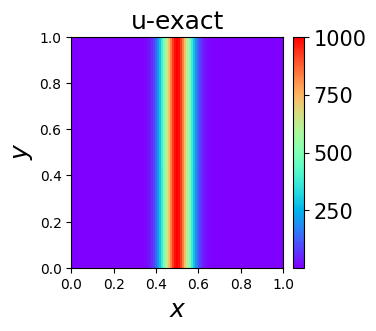

In [ ]:
X0,Y0 = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))



#h=0.03
Z0 = 1+(1000+(Y0)**2)*np.exp(-(X0-0.5)**2/(2*h*h))

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
hh = ax.imshow(Z0, interpolation='nearest', cmap='rainbow', 
              extent=[0, 1, 0, 1], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(hh, cax=cax)
cbar.ax.tick_params(labelsize=15) 
ax.set_title('u-exact',fontsize=18)
ax.set_xlabel('x', fontsize=18,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=18,fontstyle='oblique')

Text(0, 0.5, 'y')

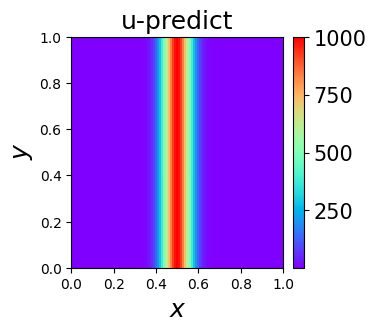

In [ ]:
tX,tY = torch.tensor(X0,dtype=torch.float32,device=device),torch.tensor(Y0,dtype=torch.float32,device=device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([tX.reshape(-1,1),tY.reshape(-1,1)],dim=1)).reshape(101,101)
U0 = tZ.cpu().numpy()
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
hh = ax.imshow(U0, interpolation='nearest', cmap='rainbow', 
              extent=[0, 1, 0, 1], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(hh, cax=cax)
cbar.ax.tick_params(labelsize=15) 
ax.set_title('u-predict',fontsize=18)
ax.set_xlabel('x', fontsize=18,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=18,fontstyle='oblique')
#plt.savefig('./img1/predict-{}-{}*{}.png'.format(alpha,m,n))

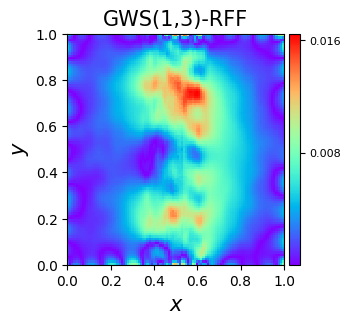

In [ ]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
hh = ax.imshow(abs(Z0-U0), interpolation='nearest', cmap='rainbow', 
              extent=[0, 1, 0, 1], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(hh, cax=cax)
cbar.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(2)#nbins=2)  # colorbar上的刻度值个数
cbar.locator = tick_locator
ax.set_title('GWS(1,3)-RFF',fontsize=15)
ax.set_xlabel('x', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=15,fontstyle='oblique')


plt.savefig('./pic/7_err_1-3-rff.pdf', format='pdf', bbox_inches='tight') 

In [ ]:
err=(Z0-U0).reshape(-1,1)#.flatten()[:,None]
error_u = np.linalg.norm(err,2)/np.linalg.norm(U0,2)
print('Relevate L2-Error u: %e' % (error_u))    
error_u = np.linalg.norm(err,1)/(err.shape[0])
print('L1-Error u: %e' % (error_u))
error_u = np.linalg.norm(err,np.inf)
print('max Error u: %e' % (error_u))

Relevate L2-Error u: 1.785061e-05
L1-Error u: 4.114778e-03
max Error u: 1.648135e-02


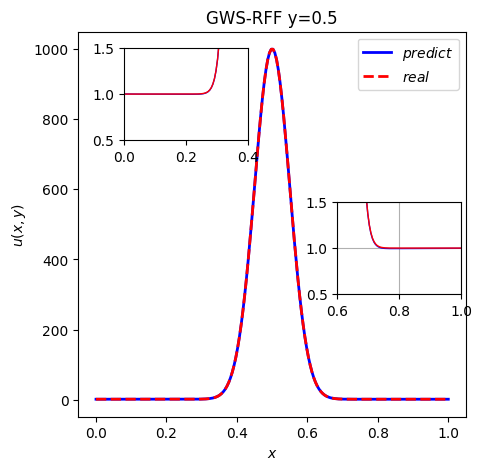

In [ ]:
x_min=1.0

x=torch.linspace(0,x_min,200).to(device)
y=0.5*torch.ones_like(x).to(device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([x.reshape(-1,1),y.reshape(-1,1)],dim=1))
U0 = tZ.cpu().numpy()


x_r=np.linspace(0,x_min,200)
y_r=0.5*np.ones_like(x_r)
#h=0.03
u = u_r(np.hstack([x_r.reshape(-1,1), y_r.reshape(-1,1)]))





fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.plot(x_r,U0, 'b-', linewidth = 2, label = '$predict$')
ax.plot(x_r,u , 'r--', linewidth = 2, label = '$real$')
#ax.plot(xt_a[:,0:1],y_a , 'r*', linewidth = 2, label = '$data$')

axins = inset_axes(ax, width="40%", height="30%", loc='lower left',
                   bbox_to_anchor=(0.1, 0.7, 0.8, 0.8),
                   bbox_transform=ax.transAxes)

axins.plot(x_r,U0, color='b', linestyle='-', linewidth=1, markersize=5,
            markeredgecolor='black', markerfacecolor='C0')

axins.plot(x_r,u , color= 'r', linestyle='-', linewidth=1,markersize=5,
            markeredgecolor='black', markerfacecolor='C3')
axins.set_xlim(0, 0.40)
axins.set_ylim(0.5, 1.5)



axins1 = inset_axes(ax, width="40%", height="30%", loc='lower left',
                   bbox_to_anchor=(0.65, 0.3, 0.8, 0.8),
                   bbox_transform=ax.transAxes)

axins1.plot(x_r,U0, color='b', linestyle='-', linewidth=1, markersize=5,
            markeredgecolor='black', markerfacecolor='C0')

axins1.plot(x_r,u , color= 'r', linestyle='-', linewidth=1,markersize=5,
            markeredgecolor='black', markerfacecolor='C3')
axins1.set_xlim(0.6, 1)
axins1.set_ylim(0.5, 1.5)






ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,y)$')    
ax.set_title('GWS-RFF y=0.5')
plt.grid()
ax.legend()

plt.savefig('./pic/7-0-1-3-rff.pdf', format='pdf', bbox_inches='tight') 

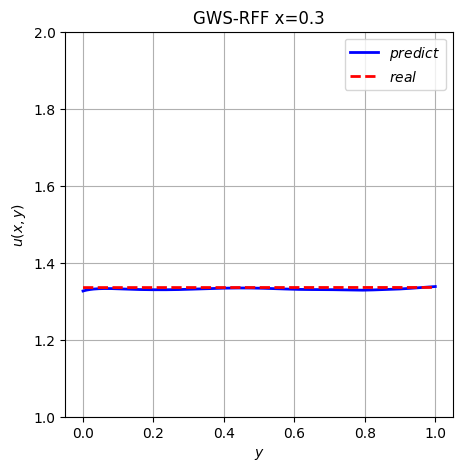

In [ ]:
x_min=1.0

y=torch.linspace(0,x_min,200).to(device)
x=0.3*torch.ones_like(x).to(device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([x.reshape(-1,1),y.reshape(-1,1)],dim=1))
U0 = tZ.cpu().numpy()


x_r=np.linspace(0,x_min,200)
y_r=0.3*np.ones_like(x_r)
#h=0.03
u = u_r(np.hstack([y_r.reshape(-1,1), x_r.reshape(-1,1)]))


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.plot(x_r,U0, 'b-', linewidth = 2, label = '$predict$')
ax.plot(x_r,u , 'r--', linewidth = 2, label = '$real$')
#ax.plot(xt_a[:,0:1],y_a , 'r*', linewidth = 2, label = '$data$')

ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')    
ax.set_title('GWS-RFF x=0.3')
ax.set_ylim([1,2])    
plt.grid()
ax.legend()

plt.savefig('./pic/7-x3-1-3-rff.pdf', format='pdf', bbox_inches='tight') 

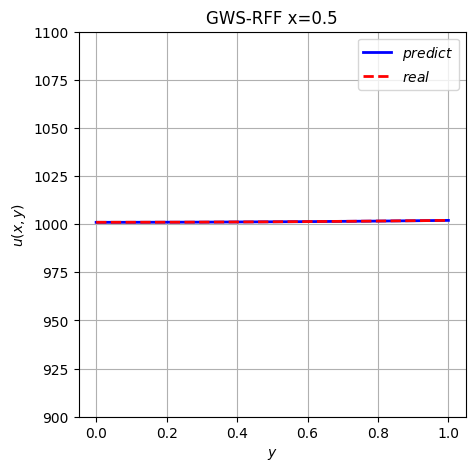

In [ ]:
x_min=1.0

y=torch.linspace(0,x_min,200).to(device)
x=0.5*torch.ones_like(x).to(device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([x.reshape(-1,1),y.reshape(-1,1)],dim=1))
U0 = tZ.cpu().numpy()


x_r=np.linspace(0,x_min,200)
y_r=0.5*np.ones_like(x_r)
#h=0.03
u = u_r(np.hstack([y_r.reshape(-1,1), x_r.reshape(-1,1)]))


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.plot(x_r,U0, 'b-', linewidth = 2, label = '$predict$')
ax.plot(x_r,u , 'r--', linewidth = 2, label = '$real$')
#ax.plot(xt_a[:,0:1],y_a , 'r*', linewidth = 2, label = '$data$')

ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')    
ax.set_title('GWS-RFF x=0.5')
#ax.set_title('PINN trained with %d sensor data '%(N_s), fontsize = 15)
#ax.set_xlim([0.95,1.8])
ax.set_ylim([900,1100])    
#ax.axis('square')
plt.grid()
ax.legend()

plt.savefig('./pic/7-x5-1-3-rff.pdf', format='pdf', bbox_inches='tight') 

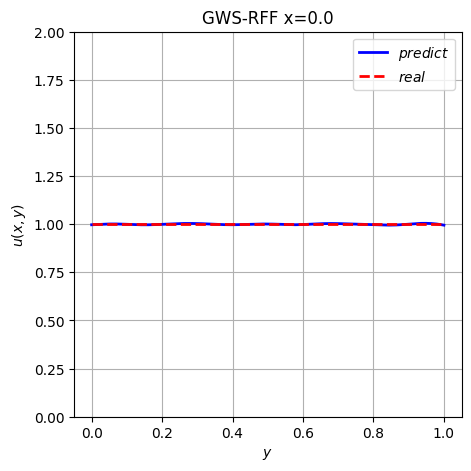

In [ ]:
x_min=1.0

y=torch.linspace(0,x_min,200).to(device)
x=0.0*torch.ones_like(x).to(device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([x.reshape(-1,1),y.reshape(-1,1)],dim=1))
U0 = tZ.cpu().numpy()


x_r=np.linspace(0,x_min,200)
y_r=0.0*np.ones_like(x_r)
#h=0.03
u = u_r(np.hstack([y_r.reshape(-1,1), x_r.reshape(-1,1)]))


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.plot(x_r,U0, 'b-', linewidth = 2, label = '$predict$')
ax.plot(x_r,u , 'r--', linewidth = 2, label = '$real$')
#ax.plot(xt_a[:,0:1],y_a , 'r*', linewidth = 2, label = '$data$')

ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')    
ax.set_title('GWS-RFF x=0.0')
#ax.set_title('PINN trained with %d sensor data '%(N_s), fontsize = 15)
#ax.set_xlim([0.95,1.8])
ax.set_ylim([0,2])    
#ax.axis('square')
plt.grid()
ax.legend()

plt.savefig('./pic/7-x0-1-3-rff.pdf', format='pdf', bbox_inches='tight') 

In [ ]:
def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='YlOrRd')

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)


    # resize
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(13, 10))   

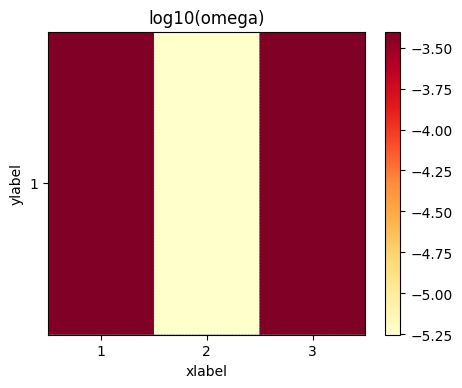

In [ ]:
data = np.log10(omega.reshape(m,n))
x_axis_size = data.shape[1]
y_axis_size = data.shape[0]
title ="log10(omega)"
xlabel="xlabel"
ylabel="ylabel"
xticklabels = range(1, x_axis_size+1) # could be text
yticklabels = range(1, y_axis_size+1) # could be text  
heatmap(data, title, xlabel, ylabel, xticklabels, yticklabels)
#plt.savefig('omega0.png'.format(alpha,m,n), format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures
#plt.close()